In [1]:
import os, sys,shutil, gc

from glob import glob
from tqdm import tqdm

import math
import random
from collections import OrderedDict
import warnings

import albumentations as A
import cv2
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import timm
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW,lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import fbeta_score, average_precision_score, roc_auc_score

import multiprocessing

from einops import rearrange, reduce, repeat
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.decoders.unet.decoder import UnetDecoder
from timm.models.resnet import resnet34d, seresnext26t_32x4d

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage

from ink_helpers import (load_image,seed_everything,
                         load_fragment, DiceLoss, FocalLoss, dice_bce_loss)

warnings.simplefilter("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
print("cpu count:", multiprocessing.cpu_count())

cuda
cpu count: 32


In [2]:
# Config:
random_seed = 42
num_workers = min(12, multiprocessing.cpu_count())

bottom_channel_idx = 29
top_channel_idx = 35
num_fluctuate_channel = 1

num_select_channel = top_channel_idx - bottom_channel_idx

block_size = 256
stride = 128

loss_type = ['bce', 'focal', 'bcedice'][2]
max_lr = 1.0e-5
weight_decay = 1.0e-3
total_epoch = 18
batch_size = 32

valid_id = '2c'

seed_everything(seed=random_seed)

In [3]:
all_frag_ids = ['1', '2a', '2b', '2c', '3']
id2dir = {id:f'./frags/train_{id}' for id in all_frag_ids}
train_id_list = [id for id in all_frag_ids if id != valid_id]
print('Train:', train_id_list)

Train: ['1', '2a', '2b', '3']


In [4]:
id2images,id2frag_mask,id2ink_mask = {},{},{}
for frag_id in tqdm(all_frag_ids):
    images,frag_mask,ink_mask = load_fragment(frag_id)
    id2images[frag_id] = images
    id2frag_mask[frag_id] = frag_mask
    id2ink_mask[frag_id] = ink_mask

100%|█████████████████████████████████████████████| 5/5 [01:15<00:00, 15.02s/it]


In [5]:
class InkDataSet2D(Dataset):
    '''
    image: (D, H, W); mask: (1, H, W)
    '''
    def __init__(self, frag_id_list, block_size, channel_slip=0, transforms=None, has_label=True):
        self.frag_id_list = frag_id_list
        self.block_size = block_size
        self.transforms = transforms
        self.has_label = has_label
        
        # get xy positions
        id_xybt_list = []
        for frag_id in frag_id_list:
            frag_mask = id2frag_mask[frag_id]
            xy_pairs = [
                (min(x,frag_mask.shape[1]-block_size), min(y,frag_mask.shape[0]-block_size))
                for x in range(0, frag_mask.shape[1]-block_size+stride, stride) 
                for y in range(0, frag_mask.shape[0]-block_size+stride, stride) 
                if np.any(frag_mask[y:y+block_size, x:x+block_size] > 0)
            ]
            bt_pairs = [(bottom_channel_idx+f, top_channel_idx+f)
                        for f in range(-channel_slip, channel_slip+1)]
            id_xybt_list += [(frag_id, *xy, *bt) for xy in xy_pairs for bt in bt_pairs]
        self.id_xybt_list = id_xybt_list
        
    def __len__(self):
        return len(self.id_xybt_list)

    def __getitem__(self, idx):
        frag_id,x,y,start_z,end_z = self.id_xybt_list[idx]

        whole_image = id2images[frag_id]
        image = whole_image[start_z:end_z, 
                            y:y+self.block_size, 
                            x:x+self.block_size] # D,H,W
        image = np.moveaxis(image, 0, 2) # H,W,D

        if self.has_label:
            whole_mask = id2ink_mask[frag_id]
            mask = whole_mask[y:y+self.block_size, 
                              x:x+self.block_size] # H,W
            
            if self.transforms:
                transformed = self.transforms(image=image, mask=mask)
                image, mask = transformed['image'], transformed['mask']
                
            image = np.moveaxis(image, 2, 0) # D,H,W
            mask = np.expand_dims(mask, 0) # 1,H,W
            
            return idx, image, mask
        else:
            if self.transforms:
                image = self.transforms(image=image)['image']
            image = np.moveaxis(image, 2, 0) # D,H,W
            return idx,image

In [6]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=1.0),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(block_size * 0.3), max_height=int(block_size * 0.3), 
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0]*num_select_channel, 
            std=[1]*num_select_channel
        ),
    ]
)

train_dataset = InkDataSet2D(
    frag_id_list=train_id_list, 
    block_size=block_size, 
    channel_slip=num_fluctuate_channel, 
    transforms=train_transform, 
    has_label=True
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    prefetch_factor=1,
)

valid_transform = A.Compose([
        A.Normalize(
            mean=[0]*num_select_channel, 
            std=[1]*num_select_channel
        ),
    ]
)

valid_dataset = InkDataSet2D(
    frag_id_list=[valid_id], 
    block_size=block_size, 
    channel_slip=0, 
    transforms=valid_transform, 
    has_label=False
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    prefetch_factor=1,
)

print('Train', len(train_dataloader), ', Valid', len(valid_dataloader), )

Train 749 , Valid 66


# Model

In [7]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops

class PatchExpand(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=2, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2*dim, bias=False) if dim_scale==2 else nn.Identity()
        self.norm = norm_layer(dim // dim_scale)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=2, p2=2, c=C//4)
        x = x.view(B,-1,C//4)
        x= self.norm(x)

        return x

class FinalPatchExpand_X4(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=4, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.dim_scale = dim_scale
        self.expand = nn.Linear(dim, 16*dim, bias=False)
        self.output_dim = dim 
        self.norm = norm_layer(self.output_dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale, c=C//(self.dim_scale**2))
        x = x.view(B,-1,self.output_dim)
        x= self.norm(x)

        return x

class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

class BasicLayer_up(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, upsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if upsample is not None:
            self.upsample = PatchExpand(input_resolution, dim=dim, dim_scale=2, norm_layer=norm_layer)
        else:
            self.upsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.upsample is not None:
            x = self.upsample(x)
        return x

class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformerSys(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030
    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 2, 2], depths_decoder=[1, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, final_upsample="expand_first", **kwargs):
        super().__init__()

        print("SwinTransformerSys expand initial----depths:{};depths_decoder:{};drop_path_rate:{};num_classes:{}".format(depths,
        depths_decoder,drop_path_rate,num_classes))

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.num_features_up = int(embed_dim * 2)
        self.mlp_ratio = mlp_ratio
        self.final_upsample = final_upsample

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build encoder and bottleneck layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)
        
        # build decoder layers
        self.layers_up = nn.ModuleList()
        self.concat_back_dim = nn.ModuleList()
        for i_layer in range(self.num_layers):
            concat_linear = nn.Linear(2*int(embed_dim*2**(self.num_layers-1-i_layer)),
            int(embed_dim*2**(self.num_layers-1-i_layer))) if i_layer > 0 else nn.Identity()
            if i_layer ==0 :
                layer_up = PatchExpand(input_resolution=(patches_resolution[0] // (2 ** (self.num_layers-1-i_layer)),
                patches_resolution[1] // (2 ** (self.num_layers-1-i_layer))), dim=int(embed_dim * 2 ** (self.num_layers-1-i_layer)), dim_scale=2, norm_layer=norm_layer)
            else:
                layer_up = BasicLayer_up(dim=int(embed_dim * 2 ** (self.num_layers-1-i_layer)),
                                input_resolution=(patches_resolution[0] // (2 ** (self.num_layers-1-i_layer)),
                                                    patches_resolution[1] // (2 ** (self.num_layers-1-i_layer))),
                                depth=depths[(self.num_layers-1-i_layer)],
                                num_heads=num_heads[(self.num_layers-1-i_layer)],
                                window_size=window_size,
                                mlp_ratio=self.mlp_ratio,
                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                drop=drop_rate, attn_drop=attn_drop_rate,
                                drop_path=dpr[sum(depths[:(self.num_layers-1-i_layer)]):sum(depths[:(self.num_layers-1-i_layer) + 1])],
                                norm_layer=norm_layer,
                                upsample=PatchExpand if (i_layer < self.num_layers - 1) else None,
                                use_checkpoint=use_checkpoint)
            self.layers_up.append(layer_up)
            self.concat_back_dim.append(concat_linear)

        self.norm = norm_layer(self.num_features)
        self.norm_up= norm_layer(self.embed_dim)

        if self.final_upsample == "expand_first":
            print("---final upsample expand_first---")
            self.up = FinalPatchExpand_X4(input_resolution=(img_size//patch_size,img_size//patch_size),dim_scale=4,dim=embed_dim)
            self.output = nn.Conv2d(in_channels=embed_dim,out_channels=self.num_classes,kernel_size=1,bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    #Encoder and Bottleneck
    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        x_downsample = []

        for layer in self.layers:
            x_downsample.append(x)
            x = layer(x)

        x = self.norm(x)  # B L C
  
        return x, x_downsample

    #Dencoder and Skip connection
    def forward_up_features(self, x, x_downsample):
        for inx, layer_up in enumerate(self.layers_up):
            if inx == 0:
                x = layer_up(x)
            else:
                x = torch.cat([x,x_downsample[3-inx]],-1)
                x = self.concat_back_dim[inx](x)
                x = layer_up(x)

        x = self.norm_up(x)  # B L C
  
        return x

    def up_x4(self, x):
        H, W = self.patches_resolution
        B, L, C = x.shape
        assert L == H*W, "input features has wrong size"

        if self.final_upsample=="expand_first":
            x = self.up(x)
            x = x.view(B,4*H,4*W,-1)
            x = x.permute(0,3,1,2) #B,C,H,W
            x = self.output(x)
            
        return x

    def forward(self, x):
        x, x_downsample = self.forward_features(x)
        x = self.forward_up_features(x,x_downsample)
        x = self.up_x4(x)

        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops
    
    
class SwinUnet(nn.Module):
    def __init__(self, img_size, in_channels, num_classes=1, zero_head=False, vis=False,
                patch_size=4, depths=[2, 2, 2, 2], window_size=8,):
        super(SwinUnet, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.img_size = img_size

        self.swin_unet = SwinTransformerSys(img_size=img_size,
                                patch_size=patch_size,
                                in_chans=in_channels,
                                num_classes=self.num_classes,
                                depths=depths,
                                window_size=window_size,
                                )

    def forward(self, x):
        logits = self.swin_unet(x)
        return logits

In [8]:
model = SwinUnet(img_size=block_size, in_channels=num_select_channel, num_classes=1, window_size=8,)
model.to(device);

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


In [9]:
# a = torch.from_numpy( np.random.choice(256, (1, 12, 256, 256))).float().cuda()
    
# with torch.no_grad():
#     with torch.cuda.amp.autocast(enabled=True):
#         output = model(a)

In [10]:
if loss_type == 'bce':
    criterion = nn.BCEWithLogitsLoss()
elif loss_type == 'focal':
    criterion = FocalLoss(alpha=1, gamma=2, use_logits=True)
if loss_type == 'bcedice':
    criterion = dice_bce_loss
    
    
optimizer = AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    epochs=total_epoch,
    steps_per_epoch=len(train_dataloader),
    max_lr=max_lr,
    pct_start=0.1,
    anneal_strategy="cos",
    div_factor=1.0e3,
    final_div_factor=1.0e1,
)
scaler = GradScaler()
Sig = nn.Sigmoid()

loss_list = [1] * 10
for epoch in range(total_epoch):
    
    # training
    gc.collect()
    with tqdm(enumerate(train_dataloader), total=len(train_dataloader)) as pbar:
        for step, (idx, img, target) in pbar:
            
            img, target = img.to(device).float(), target.to(device).float()
            
            optimizer.zero_grad()
            with autocast():
                outputs = model(img).float()
            loss = criterion(outputs, target)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            pbar.set_description(f"Ep{epoch:02d}")
            loss_list = loss_list[1:] + [loss.item()]
            pbar.set_postfix(
                OrderedDict(
                    LR=f"{scheduler.get_last_lr()[0]:.1e}",
                    Loss=f"{sum(loss_list)/10:.3f}",
                )
            )
            
    # validation
    valid_frag_mask = id2frag_mask[valid_id]
    valid_ink_mask = id2ink_mask[valid_id]
    valid_ink_predicts = np.zeros(valid_frag_mask.shape).astype(float)
    valid_ink_count = np.zeros(valid_frag_mask.shape)
    valid_xybt_list = valid_dataset.id_xybt_list
    
    model.eval()
    for idx, img in tqdm(valid_dataloader):
        img = img.to(device).float()
        with torch.no_grad():
            with autocast():
                outputs = Sig(model(img).float())

        for batch_idx,whole_idx in enumerate(idx):
            x,y = map(int, valid_xybt_list[whole_idx][1:3])

            valid_ink_predicts[y:y+block_size, x:x+block_size] += outputs.cpu()[batch_idx][0].numpy()
            valid_ink_count[y:y+block_size, x:x+block_size] += 1
    
    valid_ink_count[np.where(valid_frag_mask==0)] = 1
    valid_ink_predicts = valid_ink_predicts/valid_ink_count
    valid_ink_predicts[np.where(valid_frag_mask==0)] = 0

    valid_ink_predicts_flat = valid_ink_predicts[np.where(valid_frag_mask)].flatten()
    valid_ink_mask_flat = valid_ink_mask[np.where(valid_frag_mask)].flatten()

    map_score = average_precision_score(valid_ink_mask_flat, valid_ink_predicts_flat)
    auc_score = roc_auc_score(valid_ink_mask_flat, valid_ink_predicts_flat)
    fhalf_score = fbeta_score(valid_ink_mask_flat, valid_ink_predicts_flat>0.5, beta=0.5)
    print(f'Valid: mAP {map_score:.3f}, AUC {auc_score:.3f}, F0.5 {fhalf_score:.3f}, ')
    model.train()
    
# save weights
torch.save(
    model.state_dict(), 
    f'./weights/SwinUNet-block{block_size}-channel{bottom_channel_idx}-to{top_channel_idx}'
    f'-slip{num_fluctuate_channel}-loss{loss_type}-lr{max_lr}-wd{weight_decay}-bs{batch_size}'
    f'-valid{valid_id}-step{total_epoch*len(train_dataloader)}-seed{random_seed}-epoch{total_epoch}.pth'
)
    
gc.collect()

100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.12it/s]


Valid: mAP 0.177, AUC 0.509, F0.5 0.000, 


100%|███████████████████████████████████████████| 66/66 [00:04<00:00, 13.29it/s]


Valid: mAP 0.264, AUC 0.644, F0.5 0.008, 


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.09it/s]


Valid: mAP 0.295, AUC 0.667, F0.5 0.273, 


100%|███████████████████████████████████████████| 66/66 [00:04<00:00, 13.21it/s]


Valid: mAP 0.295, AUC 0.668, F0.5 0.325, 


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.07it/s]


Valid: mAP 0.299, AUC 0.670, F0.5 0.285, 


100%|███████████████████████████████████████████| 66/66 [00:04<00:00, 13.20it/s]


Valid: mAP 0.296, AUC 0.670, F0.5 0.329, 


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.18it/s]


Valid: mAP 0.305, AUC 0.675, F0.5 0.342, 


100%|███████████████████████████████████████████| 66/66 [00:04<00:00, 13.23it/s]


Valid: mAP 0.317, AUC 0.678, F0.5 0.301, 


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.01it/s]


Valid: mAP 0.319, AUC 0.680, F0.5 0.311, 


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.08it/s]


Valid: mAP 0.320, AUC 0.680, F0.5 0.317, 


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.03it/s]


Valid: mAP 0.313, AUC 0.679, F0.5 0.334, 


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.17it/s]


Valid: mAP 0.327, AUC 0.684, F0.5 0.348, 


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.09it/s]


Valid: mAP 0.339, AUC 0.688, F0.5 0.360, 


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.06it/s]


Valid: mAP 0.334, AUC 0.688, F0.5 0.349, 


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.14it/s]


Valid: mAP 0.331, AUC 0.686, F0.5 0.335, 


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.11it/s]


Valid: mAP 0.333, AUC 0.687, F0.5 0.338, 


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.10it/s]


Valid: mAP 0.332, AUC 0.686, F0.5 0.341, 


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 13.12it/s]


Valid: mAP 0.332, AUC 0.686, F0.5 0.341, 


0

In [11]:
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    print(i, fbeta_score(valid_ink_mask_flat, valid_ink_predicts_flat>i, beta=0.5))

0.1 0.24415979529329274
0.2 0.32979622904364064
0.3 0.34801587437390724
0.4 0.3518644032785723
0.5 0.34105904379048596
0.6 0.3152569357241125


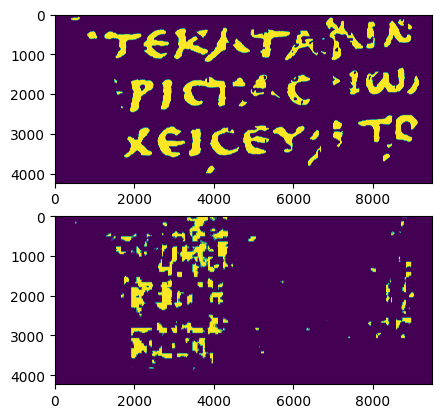

In [13]:
plt.subplot(2, 1, 1)
plt.imshow(valid_ink_mask)
plt.subplot(2, 1, 2)
plt.imshow(valid_ink_predicts>0.5)